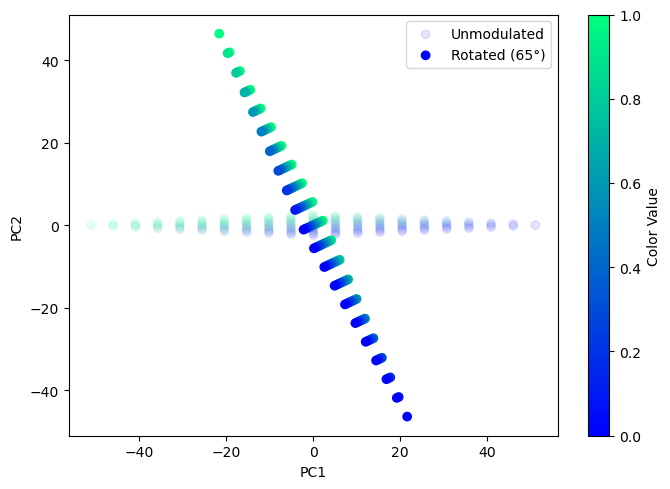

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from scipy.optimize import Bounds

np.random.seed(15)
N = 100
K = 2  # shape=0, color=1
desired_radius = 0.9
p_high = 0.2
p_low = 0.2

# -------------------------------------------------
# 1) Initialization
# -------------------------------------------------
def initialize_selectivity_matrix(N, K):
    """
    Half are shape-based, half are color-based, with a random distribution.
    The first half has shape > color (if needed, we reassign),
    and the second half is mirrored (swap shape/color).
    """
    S = np.zeros((N, K))
    # 1) Random shape (first half)
    S[:N//2, 0] = np.random.rand(N//2)
    # 2) Assign color as (0.5 - shape/2)
    S[:N//2, 1] = 0.5 - S[:N//2, 0] / 2

    # 3) If shape < color, reassign shape and recalc color
    neg_idx = (S[:N//2, 0] - S[:N//2, 1]) < 0
    if np.any(neg_idx):
        S[:N//2, 0][neg_idx] = np.random.uniform(0, 0.5, size=np.sum(neg_idx))
        # Recompute the color to match the new shape
        S[:N//2, 1][neg_idx] = 0.5 - S[:N//2, 0][neg_idx] / 2

    # 4) Mirror for the second half: color = shape, shape = color
    S[N//2:, 1] = S[:N//2, 0]
    S[N//2:, 0] = S[:N//2, 1]

    return S

def initialize_W_F(S):
    """
    W_F divides each neuron's (shape,color) by its sum.
    """
    W_F = np.zeros_like(S)
    for i in range(S.shape[0]):
        r = np.sum(S[i])
        if r > 0:
            W_F[i] = S[i] / r
        else:
            W_F[i] = S[i]
    return W_F

def initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=0.9):
    """
    Build a recurrent matrix with four blocks and scale it.
    """
    W_R = np.zeros((N, N))
    halfN = N // 2

    # shape->shape block
    ss_mask = np.random.rand(halfN, halfN) < p_high
    W_R[:halfN, :halfN][ss_mask] = np.random.rand(np.sum(ss_mask)) * 0.1

    # shape->color block
    sc_mask = np.random.rand(halfN, N - halfN) < p_low
    W_R[:halfN, halfN:][sc_mask] = np.random.rand(np.sum(sc_mask)) * 0.1

    # color->shape block
    cs_mask = np.random.rand(N - halfN, halfN) < p_low
    W_R[halfN:, :halfN][cs_mask] = np.random.rand(np.sum(cs_mask)) * 0.1

    # color->color block
    cc_mask = np.random.rand(N - halfN, N - halfN) < p_high
    W_R[halfN:, halfN:][cc_mask] = np.random.rand(np.sum(cc_mask)) * 0.1

    # No self connections
    np.fill_diagonal(W_R, 0)

    # Optionally tune W_R based on distance in S
    if WR_tuned:
        thresh = 0.2
        for i in range(N):
            for j in range(N):
                if i != j:
                    d = np.linalg.norm(S[i] - S[j])
                    if d < thresh:
                        W_R[i, j] *= (2 - d / thresh)

    # Rescale W_R so spectral radius = desired_radius
    eivals = np.linalg.eigvals(W_R)
    max_ev = np.max(np.abs(eivals))
    if max_ev > 0:
        W_R *= (desired_radius / max_ev)
    return W_R

# -------------------------------------------------
# 2) Response Computations
# -------------------------------------------------
def compute_response(W_R, W_F, shape_val, color_val, g_vector=None):
    """
    Returns steady-state response for a single (shape_val, color_val).
    """
    I = np.eye(W_R.shape[0])
    if g_vector is None:
        inv_mat = np.linalg.inv(I - W_R)
        WF_eff = W_F
    else:
        # G is diagonal with gain factors
        G = np.diag(g_vector)
        inv_mat = np.linalg.inv(I - G @ W_R)
        WF_eff = G @ W_F

    F = np.array([shape_val, color_val])
    return inv_mat @ (WF_eff @ F)

def compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=None):
    """
    Returns a [num_shape * num_color, N] array of responses
    by scanning over shape_vals x color_vals.
    """
    responses = []
    for s in shape_vals:
        for c in color_vals:
            resp = compute_response(W_R, W_F, s, c, g_vector)
            responses.append(resp)
    return np.array(responses)

# =====================================================================
# MAIN SCRIPT
# =====================================================================
if __name__ == "__main__":
    # 1) Create the network
    S = initialize_selectivity_matrix(N, K)
    W_F = initialize_W_F(S)
    W_R = initialize_W_R(N, p_high, p_low, S,
                         WR_tuned=False,
                         desired_radius=desired_radius)

    # 2) Build a 2D grid of shape & color
    grid_points = 11
    shape_vals = np.linspace(0, 1, grid_points)
    color_vals = np.linspace(0, 1, grid_points)

    # For plotting color on a scatter, track the "color_val" for each grid point
    color_list = []
    for s in shape_vals:
        for c in color_vals:
            color_list.append(c)
    color_list = np.array(color_list)  # shape [121,]

    # ---------------------------------------------------------
    # 3) Compute unmodulated responses for entire grid
    # ---------------------------------------------------------
    responses_grid_unmod = compute_grid_responses(
        W_R, W_F, shape_vals, color_vals, g_vector=None
    )  # shape => [121, N]

    # ---------------------------------------------------------
    # 4) PCA in FULL space (n_components = N)
    #    We'll use these PCA components to construct our rotation
    # ---------------------------------------------------------
    pca_full = PCA(n_components=N)
    pca_full.fit(responses_grid_unmod)  # shape [121, N]

    # U => the eigenvectors in columns (we'll transpose pca_full.components_)
    U = pca_full.components_.T  # shape (N, N)
    # We can also retrieve the explained variance if needed:
    # eigenvalues = pca_full.explained_variance_

    # ---------------------------------------------------------
    # 5) Construct an 80-degree rotation only in the top-2 PCs
    #    in an N-dimensional identity block
    # ---------------------------------------------------------
    alpha_deg = 65
    alpha_rad = np.deg2rad(alpha_deg)
    R_2x2 = np.array([
        [np.cos(alpha_rad), -np.sin(alpha_rad)],
        [np.sin(alpha_rad),  np.cos(alpha_rad)]
    ])

    # Insert this 2x2 rotation into the top-left of an N x N identity
    R_full_80 = np.eye(N)
    R_full_80[:2, :2] = R_2x2

    # Construct T_80 = U * R_full_80 * U^T
    T_80 = U @ R_full_80 @ U.T

    # ---------------------------------------------------------
    # 6) Apply the rotation in the high-dimensional space,
    #    but first center the data.
    # ---------------------------------------------------------
    responses_mean = np.mean(responses_grid_unmod, axis=0)        # shape [N,]
    responses_centered = responses_grid_unmod - responses_mean    # shape [121, N]

    responses_transformed_80 = (responses_centered @ T_80) + responses_mean

    # ---------------------------------------------------------
    # 7) For a convenient 2D visualization, do a separate PCA(2)
    #    so we can see how unmodulated vs. modulated scatter in 2D.
    # ---------------------------------------------------------
    pca_2d = PCA(n_components=2)
    pca_2d.fit(responses_grid_unmod)  # Fit on unmodulated data

    unmod_2d = pca_2d.transform(responses_grid_unmod)        # shape [121, 2]
    mod_2d   = pca_2d.transform(responses_transformed_80)    # shape [121, 2]

    # ---------------------------------------------------------
    # 8) Plot in a single 2D scatter:
    #    - Unmodulated is semi-transparent
    #    - Rotated is fully opaque
    # ---------------------------------------------------------
    plt.figure(figsize=(7,5))

    # Unmodulated (transparent)
    plt.scatter(
        unmod_2d[:, 0],
        unmod_2d[:, 1],
        c=color_list,
        cmap='winter',
        alpha=0.1,
        label='Unmodulated'
    )

    # Rotated (opaque)
    plt.scatter(
        mod_2d[:, 0],
        mod_2d[:, 1],
        c=color_list,
        cmap='winter',
        alpha=1.0,
        label='Rotated (65°)'
    )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()

    cb = plt.colorbar()
    cb.set_label("Color Value")

    plt.tight_layout()
    plt.savefig("pca_perfect.svg", dpi=500, bbox_inches="tight")
    plt.show()

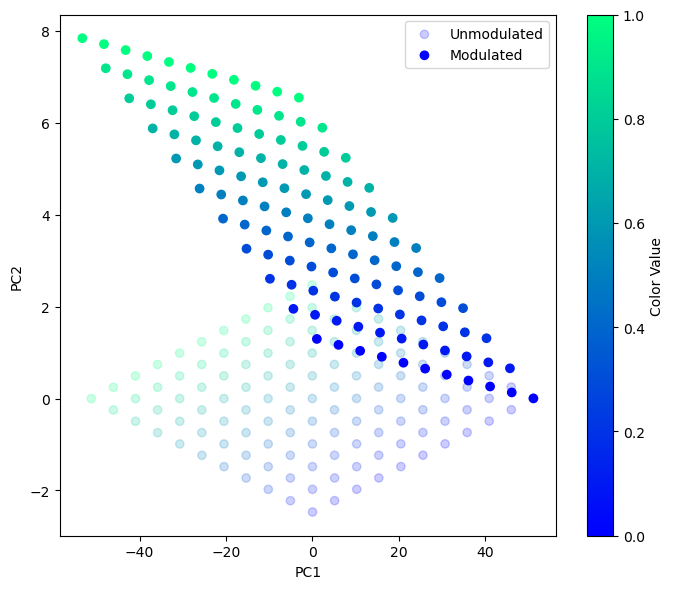

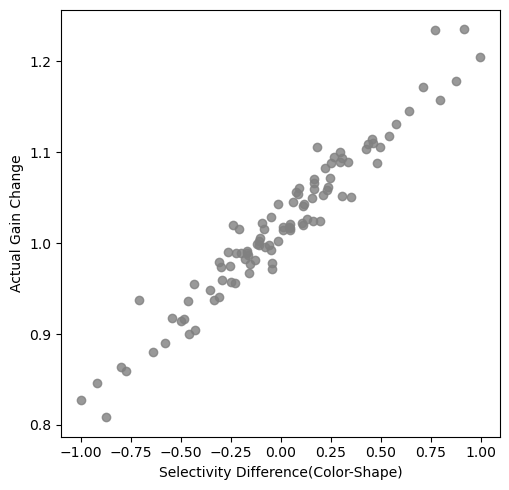

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from scipy.optimize import Bounds

np.random.seed(15)
N = 100
K = 2  # shape=0, color=1
desired_radius = 0.9
p_high = 0.2
p_low = 0.2

# -------------------------------------------------
# 1) Initialization
# -------------------------------------------------
def initialize_selectivity_matrix(N, K):
    """
    Half are shape-based, half are color-based, with a random distribution.
    The first half has shape > color (if needed, we reassign),
    and the second half is mirrored (swap shape/color).
    """
    S = np.zeros((N, K))
    # 1) Random shape (first half)
    S[:N//2, 0] = np.random.rand(N//2)
    # 2) Assign color as (0.5 - shape/2)
    S[:N//2, 1] = 0.5 - S[:N//2, 0] / 2

    # 3) If shape < color, reassign shape and recalc color
    neg_idx = (S[:N//2, 0] - S[:N//2, 1]) < 0
    if np.any(neg_idx):
        S[:N//2, 0][neg_idx] = np.random.uniform(0, 0.5, size=np.sum(neg_idx))
        # Recompute the color to match the new shape
        S[:N//2, 1][neg_idx] = 0.5 - S[:N//2, 0][neg_idx] / 2

    # 4) Mirror for the second half: color = shape, shape = color
    S[N//2:, 1] = S[:N//2, 0]
    S[N//2:, 0] = S[:N//2, 1]

    return S

def initialize_W_F(S):
    """
    W_F divides each neuron's (shape,color) by its sum.
    """
    W_F = np.zeros_like(S)
    for i in range(S.shape[0]):
        r = np.sum(S[i])
        if r > 0:
            W_F[i] = S[i] / r
        else:
            W_F[i] = S[i]
    return W_F

def initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=0.9):
    """
    Build a recurrent matrix with four blocks and scale it.
    """
    W_R = np.zeros((N, N))
    halfN = N // 2

    # shape->shape block
    ss_mask = np.random.rand(halfN, halfN) < p_high
    W_R[:halfN, :halfN][ss_mask] = np.random.rand(np.sum(ss_mask)) * 0.1

    # shape->color block
    sc_mask = np.random.rand(halfN, N - halfN) < p_low
    W_R[:halfN, halfN:][sc_mask] = np.random.rand(np.sum(sc_mask)) * 0.1

    # color->shape block
    cs_mask = np.random.rand(N - halfN, halfN) < p_low
    W_R[halfN:, :halfN][cs_mask] = np.random.rand(np.sum(cs_mask)) * 0.1

    # color->color block
    cc_mask = np.random.rand(N - halfN, N - halfN) < p_high
    W_R[halfN:, halfN:][cc_mask] = np.random.rand(np.sum(cc_mask)) * 0.1

    # No self connections
    np.fill_diagonal(W_R, 0)

    # Optionally tune W_R based on distance in S
    if WR_tuned:
        thresh = 0.2
        for i in range(N):
            for j in range(N):
                if i != j:
                    d = np.linalg.norm(S[i] - S[j])
                    if d < thresh:
                        W_R[i, j] *= (2 - d / thresh)

    # Rescale W_R so spectral radius = desired_radius
    eivals = np.linalg.eigvals(W_R)
    max_ev = np.max(np.abs(eivals))
    if max_ev > 0:
        W_R *= (desired_radius / max_ev)
    return W_R

# -------------------------------------------------
# 2) Response Computations
# -------------------------------------------------
def compute_response(W_R, W_F, shape_val, color_val, g_vector=None):
    """
    Returns steady-state response for a single (shape_val, color_val).
    """
    I = np.eye(W_R.shape[0])
    if g_vector is None:
        inv_mat = np.linalg.inv(I - W_R)
        WF_eff = W_F
    else:
        # G is diagonal with gain factors
        G = np.diag(g_vector)
        inv_mat = np.linalg.inv(I - G @ W_R)
        WF_eff = G @ W_F

    F = np.array([shape_val, color_val])
    return inv_mat @ (WF_eff @ F)

def compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=None):
    """
    Returns a [num_shape * num_color, N] array of responses
    by scanning over shape_vals x color_vals.
    """
    responses = []
    for s in shape_vals:
        for c in color_vals:
            resp = compute_response(W_R, W_F, s, c, g_vector)
            responses.append(resp)
    return np.array(responses)


# =====================================================================
# MAIN SCRIPT
# =====================================================================
if __name__ == "__main__":
    # 1) Create the network
    S = initialize_selectivity_matrix(N, K)
    W_F = initialize_W_F(S)
    W_R = initialize_W_R(N, p_high, p_low, S,
                         WR_tuned=False,
                         desired_radius=desired_radius)

    # 2) Build a 2D grid of shape & color
    grid_points = 11
    shape_vals = np.linspace(0, 1, grid_points)
    color_vals = np.linspace(0, 1, grid_points)

    # For plotting color on a scatter, track the "color_val" for each grid point
    color_list = []
    for s in shape_vals:
        for c in color_vals:
            color_list.append(c)
    color_list = np.array(color_list)  # shape [121,]

    # ---------------------------------------------------------
    # 3) Compute UNMODULATED responses
    # ---------------------------------------------------------
    responses_grid_unmod = compute_grid_responses(
        W_R, W_F, shape_vals, color_vals, g_vector=None
    )  # shape => [121, N]

    # ---------------------------------------------------------
    # 4) SIMPLE ROTATION VIA GAIN MODULATION
    #    Define each neuron's gain g_i based on "color - shape"
    #    in S. Then apply it to compute MODULATED responses.
    # ---------------------------------------------------------
    color_diff = S[:,1] - S[:,0]  # shape [N,]
    min_diff, max_diff = color_diff.min(), color_diff.max()

    # Map color_diff => [0.8, 1.2] linearly
    g_vec = np.zeros(N)
    for i in range(N):
        # Normalize color_diff within min->max
        frac = (color_diff[i] - min_diff) / (max_diff - min_diff + 1e-12)
        g_vec[i] = 0.8 + 0.4 * frac  # in [0.8, 1.2]

    # Now compute the modulated responses
    responses_grid_mod = compute_grid_responses(
        W_R, W_F, shape_vals, color_vals, g_vector=g_vec
    )

    # ---------------------------------------------------------
    # 5) PCA(2) for Visualization
    #    We'll do a separate 2D PCA on the unmodulated data for the plot.
    # ---------------------------------------------------------
    pca_2d = PCA(n_components=2)
    pca_2d.fit(responses_grid_unmod)

    unmod_2d = pca_2d.transform(responses_grid_unmod)  # shape [121, 2]
    mod_2d   = pca_2d.transform(responses_grid_mod)    # shape [121, 2]

    # ---------------------------------------------------------
    # 6) Plot #1: Unmodulated vs. Modulated in the same 2D PCA space
    # ---------------------------------------------------------
    plt.figure(figsize=(7,6))
    plt.title("")

    # Unmodulated (transparent)
    plt.scatter(
        unmod_2d[:, 0],
        unmod_2d[:, 1],
        c=color_list,
        cmap='winter',
        alpha=0.2,
        label='Unmodulated'
    )

    # Modulated (opaque)
    plt.scatter(
        mod_2d[:, 0],
        mod_2d[:, 1],
        c=color_list,
        cmap='winter',
        alpha=1.0,
        label='Modulated'
    )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()

    cb = plt.colorbar()
    cb.set_label("Color Value")

    plt.tight_layout()
    plt.savefig("../plots/pca_simple.svg", dpi=500, bbox_inches="tight")
    plt.show()

    # ---------------------------------------------------------
    # 7) Plot #2: X-axis = (color - shape) for each neuron
    #    Y-axis = "actual gain" based on ratio of mod vs. unmod average response
    # ---------------------------------------------------------
    # First, compute average firing across all stimuli for each neuron:
    # shape => [121, N], so we take mean over axis=0
    mean_unmod = np.mean(responses_grid_unmod, axis=0)  # shape [N,]
    mean_mod   = np.mean(responses_grid_mod,   axis=0)  # shape [N,]

    # "actual_gain" for neuron i => (avg_mod_i / avg_unmod_i)
    # (clip to avoid division by zero)
    actual_gain = mean_mod / np.clip(mean_unmod, 1e-10, None)

    plt.figure(figsize=(5.2,5))
    plt.title("")

    sc = plt.scatter(
        color_diff,
        actual_gain,
        alpha=0.8,
        color="gray"
    )
    plt.xlabel("Selectivity Difference(Color-Shape)")
    plt.ylabel("Actual Gain Change")

    plt.grid(False)
    plt.tight_layout()
    plt.savefig("../plots/pca_gain_change.svg", dpi=500, bbox_inches="tight")
    plt.show()


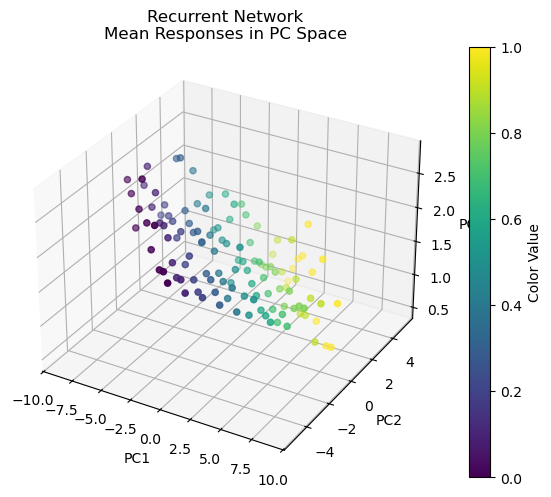

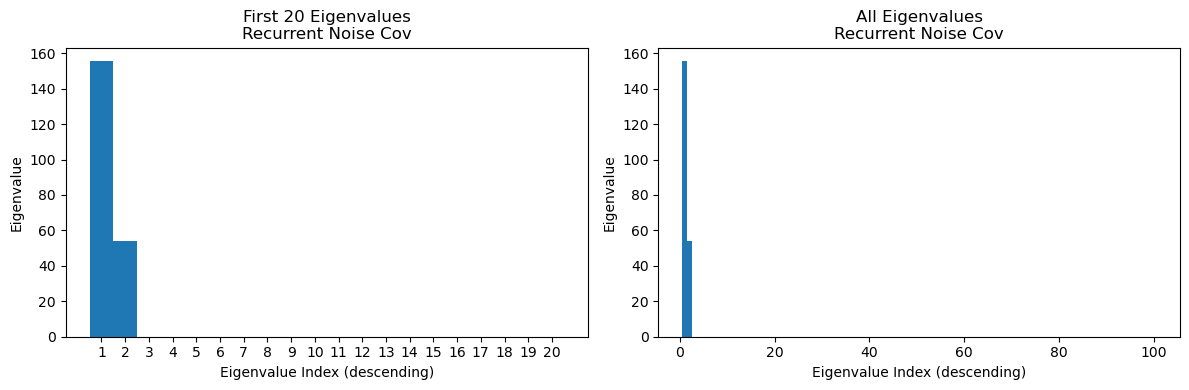

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

np.random.seed(42)

# ---------------------------
# Parameters
# ---------------------------
N = 100
K = 2       # shape=0, color=1
sigma = 1.0 # std dev of input noise => Cov(n) = sigma^2 * I_2
desired_radius = 0.9
p_high = 0.2
p_low = 0.2

# -------------------------------------------------
# 1) Initialization
# -------------------------------------------------
def initialize_selectivity_matrix(N, K):
    """
    Same as before: half shape-based, half color-based, random distribution.
    """
    S = np.zeros((N, K))
    S[:N//2, 0] = np.random.rand(N//2)
    S[:N//2, 1] = 0.5 - S[:N//2, 0]/2
    neg_idx = (S[:N//2, 0] - S[:N//2, 1]) < 0
    if np.any(neg_idx):
        S[:N//2, 0][neg_idx] = np.random.uniform(0, 0.5, size=np.sum(neg_idx))
        S[:N//2, 1][neg_idx] = 0.5 - S[:N//2, 0][neg_idx]/2
    S[N//2:, 1] = S[:N//2, 0]
    S[N//2:, 0] = S[:N//2, 1]
    return S

def initialize_W_F(S):
    """
    As before, we normalize each neuron's feedforward.
    """
    W_F = np.zeros_like(S)
    for i in range(S.shape[0]):
        s_val = S[i, 0]
        c_val = S[i, 1]
        r = s_val + c_val
        if r > 0:
            W_F[i, 0] = s_val / r
            W_F[i, 1] = c_val / r
        else:
            W_F[i] = [0, 0]
    return W_F

def initialize_W_R(N, p_high, p_low, desired_radius=0.9):
    """
    Build a random recurrent matrix with certain block structure, row-sum=0, 
    then fix the spectral radius.
    """
    halfN = N // 2
    W_R = np.zeros((N, N))

    # shape–shape block
    rand_ss = np.random.rand(halfN, halfN)
    mask_ss = rand_ss < p_high
    block_ss = np.zeros((halfN, halfN))
    block_ss[mask_ss] = np.random.rand(np.sum(mask_ss)) * 0.1

    # color–color block (mirror shape–shape)
    W_R[:halfN, :halfN] = block_ss
    W_R[halfN:, halfN:] = block_ss

    # shape->color block
    rand_sc = np.random.rand(halfN, halfN)
    mask_sc = rand_sc < p_low
    block_sc = np.zeros((halfN, halfN))
    block_sc[mask_sc] = np.random.rand(np.sum(mask_sc)) * 0.1

    # color->shape block (mirror shape->color)
    W_R[:halfN, halfN:] = block_sc
    W_R[halfN:, :halfN] = block_sc

    # no self-connections
    np.fill_diagonal(W_R, 0)

    # enforce row-sums = 0
    for i in range(N):
        row_sum = np.sum(W_R[i, :])
        W_R[i, :] -= row_sum / N
    np.fill_diagonal(W_R, 0)

    # fix spectral radius
    eivals = np.linalg.eigvals(W_R)
    max_ev = np.max(np.abs(eivals))
    if max_ev > 0:
        W_R *= (desired_radius / max_ev)

    return W_R

# -------------------------------------------------
# 2) Recurrent Response (Mean)
#    r = (I - W_R)^{-1} W_F f
# -------------------------------------------------
def compute_recurrent_response(W_R, W_F, shape_val, color_val):
    I = np.eye(N)
    inv_mat = np.linalg.inv(I - W_R)
    f_vec = np.array([shape_val, color_val])
    return inv_mat @ (W_F @ f_vec)

# -------------------------------------------------
# 3) Noise Covariance
#    Cov(r) = (I - W_R)^(-1) * W_F * Cov(n) * W_F^T * (I - W_R)^(-1)^T
#    with Cov(n) = sigma^2 I_2.
# -------------------------------------------------
def compute_noise_covariance_recurrent(W_R, W_F, sigma=1.0):
    I = np.eye(N)
    inv_mat = np.linalg.inv(I - W_R)
    # W_F is N x 2, so W_F * I_2 * W_F^T = W_F W_F^T
    # => Cov(r) = inv_mat @ [ sigma^2 * (W_F W_F^T) ] @ inv_mat^T
    WFWT = W_F @ W_F.T
    return (sigma**2) * (inv_mat @ WFWT @ inv_mat.T)

# ================================================================
# MAIN: Recurrent
# ================================================================
if __name__ == "__main__":
    # 1) Build network
    S = initialize_selectivity_matrix(N, K)
    W_F = initialize_W_F(S)
    W_R = initialize_W_R(N, p_high, p_low, desired_radius=desired_radius)

    # 2) Grid of shape,color => get mean responses
    grid_points = 11
    shape_vals = np.linspace(0, 1, grid_points)
    color_vals = np.linspace(0, 1, grid_points)

    responses_list = []
    color_list = []
    for s_val in shape_vals:
        for c_val in color_vals:
            mean_resp = compute_recurrent_response(W_R, W_F, s_val, c_val)
            responses_list.append(mean_resp)
            color_list.append(c_val)

    responses_array = np.array(responses_list)  # shape [grid_points^2, N]
    color_list = np.array(color_list)

    # 3) PCA of the mean responses
    pca = PCA(n_components=3)
    pca.fit(responses_array)
    pc_proj = pca.transform(responses_array)

    # 4) 3D scatter in PC space
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Recurrent Network\nMean Responses in PC Space")
    sc = ax.scatter(pc_proj[:,0], pc_proj[:,1], pc_proj[:,2],
                    c=color_list, cmap='viridis', s=20)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    cb = plt.colorbar(sc)
    cb.set_label("Color Value")
    plt.tight_layout()
    plt.show()

    # 5) Noise Covariance & Eigenvalues
    Cov_rec = compute_noise_covariance_recurrent(W_R, W_F, sigma=sigma)
    eigvals = np.linalg.eigvalsh(Cov_rec)
    eigvals_sorted = np.sort(eigvals)[::-1]

    # 6) Plot the Eigenvalue Spectrum
    fig2, axs = plt.subplots(1, 2, figsize=(12,4))

    # (A) First 20
    num_show = 20
    xs_20 = np.arange(1, num_show+1)
    axs[0].bar(xs_20, eigvals_sorted[:num_show], width=1.0)
    axs[0].set_title("First 20 Eigenvalues\nRecurrent Noise Cov")
    axs[0].set_xlabel("Eigenvalue Index (descending)")
    axs[0].set_ylabel("Eigenvalue")
    axs[0].set_xticks(xs_20)

    # (B) Full
    xs_all = np.arange(1, N+1)
    axs[1].bar(xs_all, eigvals_sorted, width=1.0)
    axs[1].set_title("All Eigenvalues\nRecurrent Noise Cov")
    axs[1].set_xlabel("Eigenvalue Index (descending)")
    axs[1].set_ylabel("Eigenvalue")

    plt.tight_layout()
    plt.show()

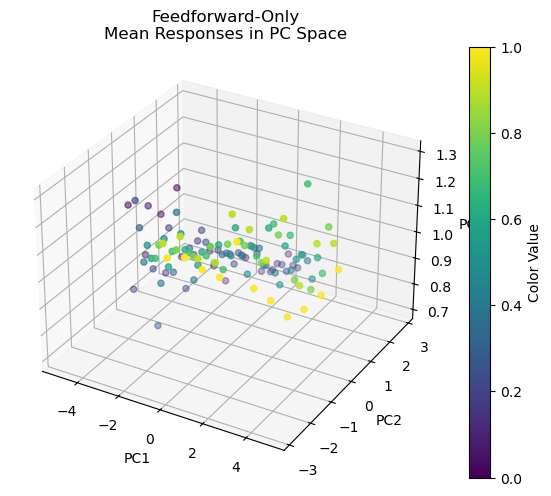

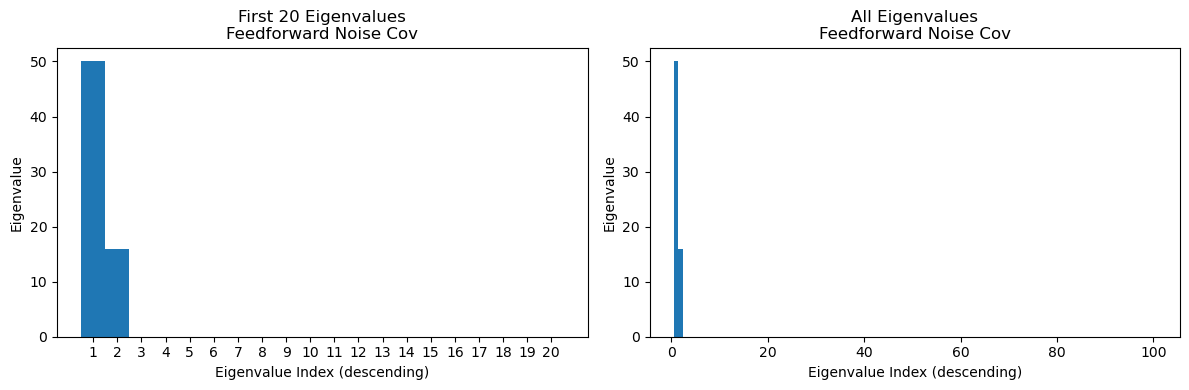

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

np.random.seed(42)

# ---------------------------
# Parameters
# ---------------------------
N = 100     # Number of neurons
K = 2       # shape=0, color=1 (two input dimensions)
sigma = 1.0 # std dev of input noise => Cov(n) = sigma^2 * I_2

# -------------------------------------------------
# 1) Initialization
# -------------------------------------------------
def initialize_selectivity_matrix(N, K):
    """
    Half are shape-based, half are color-based, with a random distribution.
    The first half has shape > color (if needed, reassign),
    and the second half is mirrored (swap shape/color).
    """
    S = np.zeros((N, K))
    # 1) Random shape (first half)
    S[:N//2, 0] = np.random.rand(N//2)
    # 2) Assign color as (0.5 - shape/2)
    S[:N//2, 1] = 0.5 - S[:N//2, 0] / 2

    # 3) If shape < color, reassign
    neg_idx = (S[:N//2, 0] - S[:N//2, 1]) < 0
    if np.any(neg_idx):
        S[:N//2, 0][neg_idx] = np.random.uniform(0, 0.5, size=np.sum(neg_idx))
        S[:N//2, 1][neg_idx] = 0.5 - S[:N//2, 0][neg_idx] / 2

    # 4) Mirror for second half
    S[N//2:, 1] = S[:N//2, 0]
    S[N//2:, 0] = S[:N//2, 1]
    return S

def initialize_W_F(S):
    """
    Simple approach: each neuron's feedforward is normalized shape vs. color
    based on S.  (Same as your old code.)
    """
    W_F = np.zeros_like(S)
    for i in range(S.shape[0]):
        s_val = S[i, 0]
        c_val = S[i, 1]
        r = s_val + c_val
        if r > 0:
            W_F[i, 0] = s_val / r
            W_F[i, 1] = c_val / r
        else:
            W_F[i] = [0, 0]
    return W_F

# -------------------------------------------------
# 2) Feedforward-Only Response (Mean)
# -------------------------------------------------
def compute_feedforward_response(W_F, shape_val, color_val):
    """
    r = W_F * (f), ignoring noise here -> just the mean.
    f = [shape_val, color_val]
    """
    f_vec = np.array([shape_val, color_val])
    return W_F @ f_vec

# -------------------------------------------------
# 3) Compute the Noise Covariance
#    Cov(r) = sigma^2 * W_F * W_F^T
# -------------------------------------------------
def compute_noise_covariance_feedforward(W_F, sigma=1.0):
    # Cov(n) = sigma^2 I_2  => Cov(r) = W_F Cov(n) W_F^T
    return (sigma**2) * (W_F @ W_F.T)

# ================================================================
# MAIN: Feedforward-Only
# ================================================================
if __name__ == "__main__":
    # 1) Build network
    S = initialize_selectivity_matrix(N, K)
    W_F = initialize_W_F(S)

    # 2) Build a 2D grid of shape & color, get the *mean* responses
    grid_points = 11
    shape_vals = np.linspace(0, 1, grid_points)
    color_vals = np.linspace(0, 1, grid_points)

    # We'll store the mean responses across the entire grid
    responses_list = []
    color_list = []
    for s_val in shape_vals:
        for c_val in color_vals:
            mean_resp = compute_feedforward_response(W_F, s_val, c_val)
            responses_list.append(mean_resp)
            color_list.append(c_val)
    responses_array = np.array(responses_list)   # shape [grid_points^2, N]
    color_list = np.array(color_list)

    # 3) PCA on the mean responses
    pca = PCA(n_components=3)
    pca.fit(responses_array)
    pc_proj = pca.transform(responses_array)  # shape [grid_points^2, 3]

    # 4) 3D Scatter of the mean responses in PC space
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Feedforward-Only\nMean Responses in PC Space")
    sc = ax.scatter(pc_proj[:,0], pc_proj[:,1], pc_proj[:,2],
                    c=color_list, cmap='viridis', s=20)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    cb = plt.colorbar(sc)
    cb.set_label("Color Value")
    plt.tight_layout()
    plt.show()

    # 5) Noise Covariance & Eigenvalues
    Cov_ff = compute_noise_covariance_feedforward(W_F, sigma=sigma)
    eigvals = np.linalg.eigvalsh(Cov_ff)
    # sort descending
    eigvals_sorted = np.sort(eigvals)[::-1]

    # 6) Plot the Eigenvalue Spectrum (bar plots)
    fig2, axs = plt.subplots(1, 2, figsize=(12,4))

    # (A) First 20 eigenvalues
    num_show = 20
    xs_20 = np.arange(1, num_show+1)
    axs[0].bar(xs_20, eigvals_sorted[:num_show], width=1.0)
    axs[0].set_title("First 20 Eigenvalues\nFeedforward Noise Cov")
    axs[0].set_xlabel("Eigenvalue Index (descending)")
    axs[0].set_ylabel("Eigenvalue")
    axs[0].set_xticks(xs_20)

    # (B) Full spectrum
    xs_all = np.arange(1, N+1)
    axs[1].bar(xs_all, eigvals_sorted, width=1.0)
    axs[1].set_title("All Eigenvalues\nFeedforward Noise Cov")
    axs[1].set_xlabel("Eigenvalue Index (descending)")
    axs[1].set_ylabel("Eigenvalue")

    plt.tight_layout()
    plt.show()

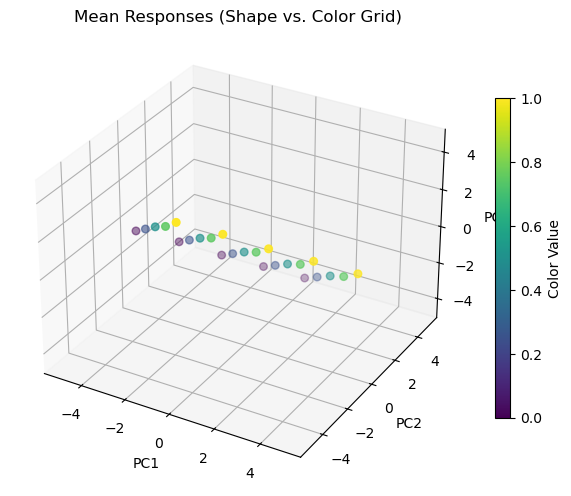

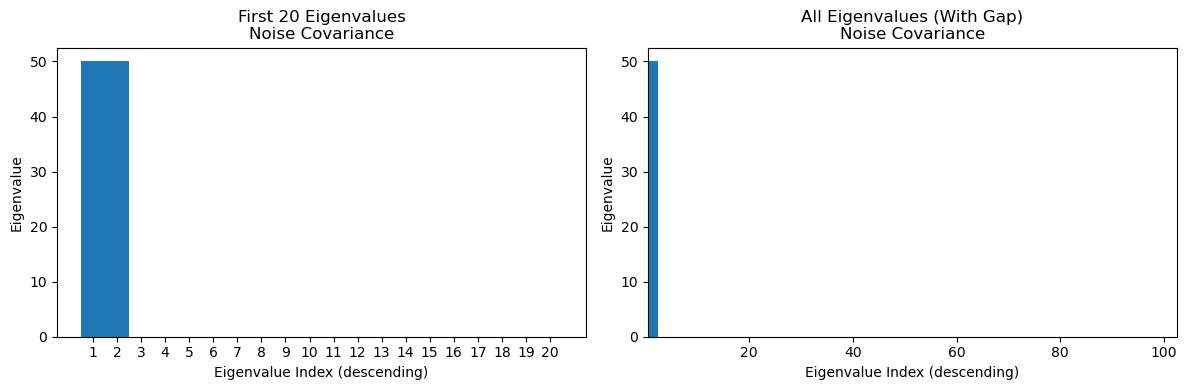

Top two eigenvalues of noise covariance:
lambda_1 = 50.00000000000002
lambda_2 = 50.000000000000014
Sum of rest = 9.9581e-15


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

np.random.seed(42)

# ---------------------------------------------------------
# 1) Parameters
# ---------------------------------------------------------
N = 100
assert N % 2 == 0, "N must be even so we can split shape vs. color subpopulations."
halfN = N // 2

sigma = 1.0  # std dev of the input noise => Cov(n) = sigma^2 * I_2
desired_radius = 0.8  # spectral radius < 1 for stability

# ---------------------------------------------------------
# 2) Build the feedforward matrix W_F
#    Half of the neurons get only shape, the other half only color.
# ---------------------------------------------------------
S = np.zeros((N, 2))
S[:halfN, 0] = 1.0  # shape subpopulation
S[halfN:, 1] = 1.0  # color subpopulation

W_F = S.copy()  # So that each neuron's feedforward is exactly shape-only or color-only

# ---------------------------------------------------------
# 3) Build a block-diagonal recurrent matrix W_R
#    - top-left block (shape-shape), bottom-right block (color-color)
#    - identical blocks => shape & color get the same net gain
#    - row-sums=0 in each block
# ---------------------------------------------------------
W_R = np.zeros((N, N))

def make_random_block(block_size):
    """Create a block_size x block_size random matrix with row-sums=0."""
    block = 0.5 * np.random.randn(block_size, block_size)  # some random scale
    for i in range(block_size):
        row_sum = np.sum(block[i, :])
        block[i, :] -= row_sum / block_size  # enforce row-sums=0
    return block

# shape block
block_shape = make_random_block(halfN)
# color block = identical to shape block (for symmetrical amplification)
block_color = block_shape.copy()

# place them in top-left, bottom-right
W_R[:halfN, :halfN] = block_shape
W_R[halfN:, halfN:] = block_color

# fix spectral radius
eigvals = np.linalg.eigvals(W_R)
max_ev = np.max(np.abs(eigvals))
if max_ev > 0:
    W_R *= (desired_radius / max_ev)

# ---------------------------------------------------------
# 4) Mean Response (no noise)
#    r = (I - W_R)^{-1} W_F [shape, color]^T
# ---------------------------------------------------------
def compute_recurrent_response(shape_val, color_val):
    I = np.eye(N)
    inv_mat = np.linalg.inv(I - W_R)
    f_vec = np.array([shape_val, color_val])  # 2D
    return inv_mat @ (W_F @ f_vec)

# ---------------------------------------------------------
# 5) Noise Covariance
#    Cov(r) = sigma^2 * (I - W_R)^{-1} * W_F W_F^T * (I - W_R)^{-1}^T
# ---------------------------------------------------------
def compute_noise_covariance():
    I = np.eye(N)
    inv_mat = np.linalg.inv(I - W_R)
    WFWT = W_F @ W_F.T  # shape (N x N)
    Cov = (sigma**2) * (inv_mat @ WFWT @ inv_mat.T)
    return Cov

# ---------------------------------------------------------
# 6) Plot the network's mean responses for a shape-color grid
# ---------------------------------------------------------
grid_points = 5
shape_vals = np.linspace(0, 1, grid_points)
color_vals = np.linspace(0, 1, grid_points)

resp_list = []
color_list = []
for sv in shape_vals:
    for cv in color_vals:
        r_mean = compute_recurrent_response(sv, cv)
        resp_list.append(r_mean)
        color_list.append(cv)

resp_array = np.array(resp_list)  # (grid_points^2, N)
color_array = np.array(color_list)

pca = PCA(n_components=3)
pca.fit(resp_array)
proj = pca.transform(resp_array)

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(proj[:,0], proj[:,1], proj[:,2], c=color_array, cmap='viridis', s=30)
ax.set_title("Mean Responses (Shape vs. Color Grid)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
cb = plt.colorbar(sc, shrink=0.7)
cb.set_label("Color Value")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 7) Compute the noise covariance & its eigenvalues
# ---------------------------------------------------------
Cov = compute_noise_covariance()
eigvals = np.linalg.eigvalsh(Cov)
eigvals_sorted = np.sort(eigvals)[::-1]

# ---------------------------------------------------------
# 8) Plot Eigenvalues with a gap for the first two
# ---------------------------------------------------------

fig2, axs = plt.subplots(1, 2, figsize=(12,4))

# (A) FIRST 20 eigenvalues, no gap
num_show = 20
xs_20 = np.arange(1, num_show+1)
axs[0].bar(xs_20, eigvals_sorted[:num_show], width=1.0)
axs[0].set_title("First 20 Eigenvalues\nNoise Covariance")
axs[0].set_xlabel("Eigenvalue Index (descending)")
axs[0].set_ylabel("Eigenvalue")
axs[0].set_xticks(xs_20)

# (B) ALL eigenvalues, with a gap after the first 2
# We'll put the first two bars at x=1,2, skip x=3,
# and continue from x=4.. for the rest
x_vals = []
y_vals = []
count = 0
for i, val in enumerate(eigvals_sorted):
    if i < 2:
        # i=0 -> x=1, i=1 -> x=2
        x_vals.append(i+1)
    else:
        # skip x=3, so i=2 -> x=4, i=3 -> x=5, ...
        x_vals.append(i+2)  # i+2 means a shift by 2
    y_vals.append(val)

axs[1].bar(x_vals, y_vals, width=1.0)
axs[1].set_title("All Eigenvalues (With Gap)\nNoise Covariance")
axs[1].set_xlabel("Eigenvalue Index (descending)")
axs[1].set_ylabel("Eigenvalue")

# Adjust x-limits so the gap is visible
axs[1].set_xlim([0.5, N+2.5])

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 9) Print top eigenvalues
# ---------------------------------------------------------
print("Top two eigenvalues of noise covariance:")
print("lambda_1 =", eigvals_sorted[0])
print("lambda_2 =", eigvals_sorted[1])
print(f"Sum of rest = {eigvals_sorted[2:].sum():.4e}")

W_R_rank1 shape: (100, 100)
Eigenvalues of W_R_rank1:
 [ 9.90000000e-01+0.00000000e+00j  8.65521029e-17+0.00000000e+00j
 -2.16196881e-17+0.00000000e+00j  2.89985989e-17+0.00000000e+00j
  1.89152457e-17+0.00000000e+00j  1.55681790e-17+0.00000000e+00j
  1.38912316e-17+0.00000000e+00j -1.41633408e-17+0.00000000e+00j
 -1.28962202e-17+5.93263428e-19j -1.28962202e-17-5.93263428e-19j
 -1.20426492e-17+0.00000000e+00j  1.15996143e-17+1.12380482e-19j
  1.15996143e-17-1.12380482e-19j -1.07009046e-17+0.00000000e+00j
  1.02868245e-17+3.27096577e-19j  1.02868245e-17-3.27096577e-19j
 -9.84603006e-18+8.45105453e-19j -9.84603006e-18-8.45105453e-19j
  9.41242910e-18+0.00000000e+00j  8.55340338e-18+0.00000000e+00j
 -8.37371176e-18+0.00000000e+00j -7.38807699e-18+0.00000000e+00j
 -6.75418890e-18+0.00000000e+00j  6.98799795e-18+8.59924282e-19j
  6.98799795e-18-8.59924282e-19j  7.11708629e-18+0.00000000e+00j
  6.73108868e-18+0.00000000e+00j  6.20501217e-18+0.00000000e+00j
  5.92568376e-18+0.00000000e+00j -6

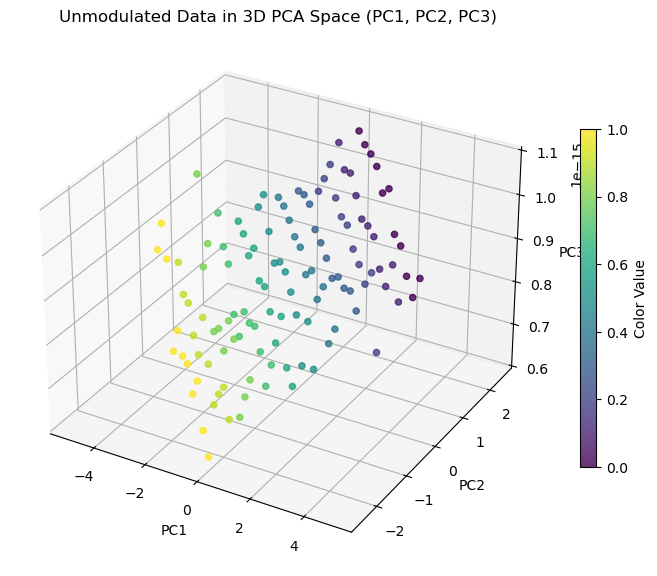

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Just ensures 3D axes in some environments
from sklearn.decomposition import PCA

np.random.seed(15)

# -------------------------------------------------------
# 1) Initialization functions
# -------------------------------------------------------
def initialize_selectivity_matrix(N, K):
    """
    Half of the neurons prefer shape>color, the other half is mirrored (color>shape).
    """
    S = np.zeros((N, K))
    halfN = N // 2

    # First half: random shape in [0,1], color = 0.5 - shape/2
    S[:halfN, 0] = np.random.rand(halfN)  # shape
    S[:halfN, 1] = 0.5 - S[:halfN, 0]/2   # color

    # Ensure shape >= color; if not, re-draw shape
    neg_idx = (S[:halfN, 0] - S[:halfN, 1]) < 0
    if np.any(neg_idx):
        S[:halfN, 0][neg_idx] = np.random.uniform(0, 0.5, np.sum(neg_idx))
        S[:halfN, 1][neg_idx] = 0.5 - S[:halfN, 0][neg_idx] / 2

    # Second half: mirror shape/color
    S[halfN:, 1] = S[:halfN, 0]
    S[halfN:, 0] = S[:halfN, 1]

    return S

def initialize_W_F(S):
    """
    Feedforward matrix W_F: each neuron’s shape/color weights sum to 1.
    """
    W_F = np.zeros_like(S)
    for i in range(S.shape[0]):
        total = np.sum(S[i])
        if total > 0:
            W_F[i] = S[i] / total
        else:
            W_F[i] = 0
    return W_F

def compute_response(W_R, W_F, shape_val, color_val):
    """
    Steady-state response x_ss = (I - W_R)^(-1) * (W_F @ [shape_val, color_val]),
    given recurrent matrix W_R.
    """
    N = W_R.shape[0]
    I = np.eye(N)
    inv_mat = np.linalg.inv(I - W_R)
    F = np.array([shape_val, color_val])  # external input
    return inv_mat @ (W_F @ F)

def compute_grid_responses(W_R, W_F, shape_vals, color_vals):
    """
    Generate responses over all (shape_val, color_val) pairs.
    Returns array of shape (len(shape_vals)*len(color_vals), N).
    """
    responses = []
    for s in shape_vals:
        for c in color_vals:
            resp = compute_response(W_R, W_F, s, c)
            responses.append(resp)
    return np.array(responses)

# -------------------------------------------------------
# 2) Main code
# -------------------------------------------------------
if __name__ == "__main__":
    # A) Define population and feedforward
    N = 100      # number of neurons
    K = 2        # shape=0, color=1
    S = initialize_selectivity_matrix(N, K)
    W_F = initialize_W_F(S)

    # B) We'll compute unmodulated responses by setting W_R=0
    W_R_zero = np.zeros((N, N))

    # Build a shape x color grid
    grid_points = 11
    shape_vals = np.linspace(0, 1, grid_points)
    color_vals = np.linspace(0, 1, grid_points)

    # Gather the color values for use in plotting
    color_list = []
    for s in shape_vals:
        for c in color_vals:
            color_list.append(c)
    color_list = np.array(color_list)  # shape (grid_points^2,)

    # C) Compute unmodulated (old) responses
    responses_unmod = compute_grid_responses(W_R_zero, W_F, shape_vals, color_vals)
    # shape => (121, N)

    # D) PCA: Extract PC1, PC2, PC3 from unmodulated data
    pca_3 = PCA(n_components=3)
    pca_3.fit(responses_unmod)  # shape => (121, N)

    # pca_3.components_ is shape (3, N).
    #   - pca_3.components_[0] -> PC1
    #   - pca_3.components_[1] -> PC2
    #   - pca_3.components_[2] -> PC3
    v3_old = pca_3.components_[2].copy()  # "old PC3"
    # Normalize
    v3_old /= np.linalg.norm(v3_old)

    # E) Construct W_R so that v3_old is the top eigenvector
    desired_lambda = 0.99  # largest eigenvalue
    W_R_rank1 = desired_lambda * np.outer(v3_old, v3_old)

    # F) Verify
    eigvals, eigvecs = np.linalg.eig(W_R_rank1)
    idx_max = np.argmax(np.abs(eigvals))
    top_eigval = eigvals[idx_max]
    top_eigvec = eigvecs[:, idx_max]
    # Compare sign-corrected alignment with v3_old
    alignment = np.abs(np.dot(top_eigvec, v3_old))  # should be close to 1

    print("W_R_rank1 shape:", W_R_rank1.shape)
    print("Eigenvalues of W_R_rank1:\n", eigvals)
    print(f"Largest eigenvalue => {top_eigval:.3f}")
    print(f"Alignment of top eigenvector with old PC3 => {alignment:.3f}")

    # G) For a final 3D plot of the old data
    #    Project unmodulated data into (PC1, PC2, PC3) coordinate system
    old_data_3d = pca_3.transform(responses_unmod)  # shape => (121, 3)

    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(
        old_data_3d[:,0], old_data_3d[:,1], old_data_3d[:,2],
        c=color_list, cmap='viridis', alpha=0.8
    )
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    cb = fig.colorbar(sc, ax=ax, shrink=0.6)
    cb.set_label("Color Value")

    plt.title("Unmodulated Data in 3D PCA Space (PC1, PC2, PC3)")
    plt.tight_layout()
    plt.show()

    # At this point, we have a W_R whose largest eigenvector is exactly the old PC3.
    # We do *not* re-generate new responses with this W_R, since you said no modulation is needed.
